In [2]:
import os
import sys

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))

In [11]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [17]:
RANDOM_STATE = 42
OUT_DIR = "probe_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

In [9]:
df = pd.read_csv("../datasets/probing_dataset_gpt2.csv")

In [10]:
feature_cols = [c for c in df.columns if re.fullmatch(r"h_\d+", c)]
feature_cols = sorted(feature_cols, key=lambda x: int(x.split("_")[1]))

Внешняя 5-fold CV + внутренняя 3-fold для подбора C

In [12]:
def evaluate_layer_cv(df_layer: pd.DataFrame,
                      outer_splits: int = 5,
                      inner_splits: int = 3,
                      random_state: int = 42):

    X = df_layer[feature_cols].values
    y = df_layer["target"].values

    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=random_state)
    inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=random_state)

    acc_scores, f1_scores = [], []
    best_Cs = []

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            multi_class="multinomial",
            solver="lbfgs",
            max_iter=2000,
        ))
    ])

    Cs = np.logspace(-2, 2, 7)

    param_grid = {
        "clf__C": Cs
    }

    for train_idx, test_idx in outer_cv.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        gs = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid,
            scoring="f1_macro",
            cv=inner_cv,
            n_jobs=-1,
            refit=True,
            verbose=0
        )
        gs.fit(X_train, y_train)

        best_Cs.append(gs.best_params_["clf__C"])

        y_pred = gs.predict(X_test)
        acc_scores.append(accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred, average="macro"))

    return acc_scores, f1_scores, np.median(best_Cs)

Фиксированный hold-out для построения confusion matrix

In [13]:

def fit_for_confusion(df_layer: pd.DataFrame, C: float, random_state: int = 42, test_size: float = 0.2):
    X = df_layer[feature_cols].values
    y = df_layer["target"].values
    labels = np.unique(y)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            multi_class="multinomial",
            solver="lbfgs",
            max_iter=2000,
            C=C
        ))
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    cm = confusion_matrix(y_test, y_pred, labels=labels)
    return cm, labels

In [18]:
all_layers = sorted(df["layer"].unique())
rows = []

layer_to_bestC = {}

for layer in all_layers:
    df_layer = df[df["layer"] == layer].reset_index(drop=True)

    class_counts = df_layer["target"].value_counts().to_dict()

    accs, f1s, bestC_median = evaluate_layer_cv(
        df_layer,
        outer_splits=5,
        inner_splits=3,
        random_state=RANDOM_STATE
    )

    row = {
        "layer": layer,
        "n_samples": len(df_layer),
        "n_classes": df_layer["target"].nunique(),
        "accuracy_mean": float(np.mean(accs)),
        "accuracy_std": float(np.std(accs, ddof=1)),
        "f1_macro_mean": float(np.mean(f1s)),
        "f1_macro_std": float(np.std(f1s, ddof=1)),
        "bestC_median": float(bestC_median)
    }
    rows.append(row)
    layer_to_bestC[layer] = bestC_median

results_df = pd.DataFrame(rows).sort_values("f1_macro_mean", ascending=False).reset_index(drop=True)
print("\nРезультаты по слоям (усреднение по внешней 5-fold CV)")
print(results_df)

results_csv = os.path.join(OUT_DIR, "probe_results_by_layer.csv")
results_df.to_csv(results_csv, index=False)
print(f"\nСохранено: {results_csv}")

/opt/miniconda3/envs/SIGNAL-analysis/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/SIGNAL-analysis/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/SIGNAL-analysis/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/SIGNAL-analysis/lib/python3.12/site-packages/s


Результаты по слоям (усреднение по внешней 5-fold CV)
    layer  n_samples  n_classes  accuracy_mean  accuracy_std  f1_macro_mean  \
0       8        600          4       0.486667      0.024721       0.489134   
1       5        600          4       0.488333      0.054836       0.488031   
2      10        600          4       0.470000      0.022515       0.474982   
3       9        600          4       0.468333      0.031950       0.473178   
4       6        600          4       0.466667      0.038640       0.468951   
5       7        600          4       0.463333      0.019185       0.466975   
6      12        600          4       0.461667      0.044331       0.466403   
7      11        600          4       0.446667      0.022515       0.448786   
8       3        600          4       0.436667      0.041079       0.437784   
9       4        600          4       0.426667      0.029698       0.427324   
10      2        600          4       0.408333      0.068971       0.403813 

/opt/miniconda3/envs/SIGNAL-analysis/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


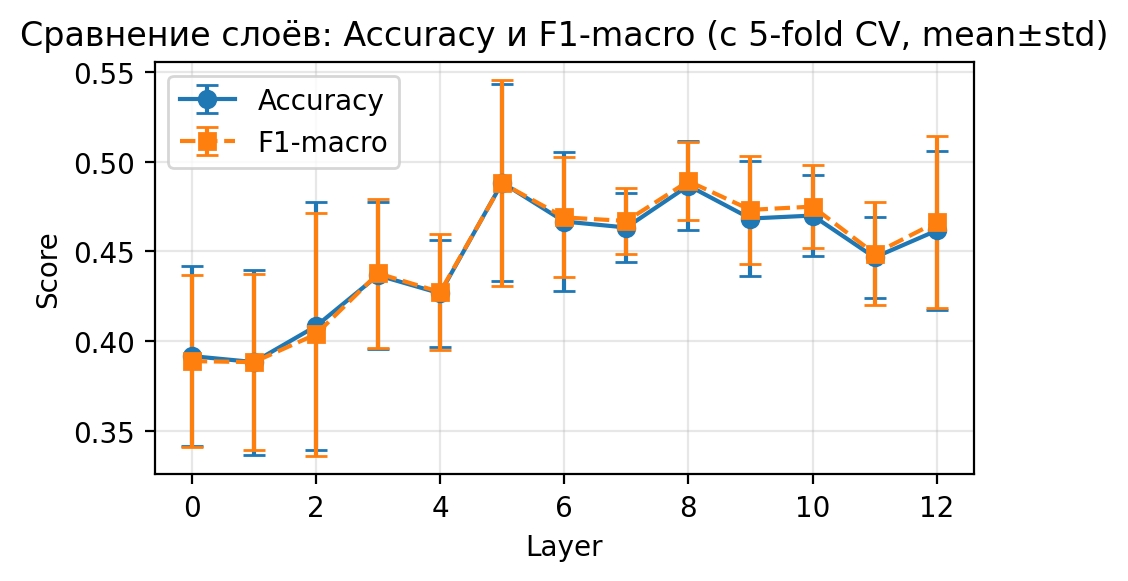

Сохранено: probe_outputs/metrics_by_layer.png


In [20]:
fig, ax = plt.subplots(figsize=(5, 3))
layers_sorted = sorted(all_layers)
plot_df = results_df.sort_values("layer")

ax.errorbar(
    plot_df["layer"], plot_df["accuracy_mean"],
    yerr=plot_df["accuracy_std"],
    fmt="o-", capsize=4, label="Accuracy"
)
ax.errorbar(
    plot_df["layer"], plot_df["f1_macro_mean"],
    yerr=plot_df["f1_macro_std"],
    fmt="s--", capsize=4, label="F1-macro"
)
ax.set_xlabel("Layer")
ax.set_ylabel("Score")
ax.set_title("Сравнение слоёв: Accuracy и F1-macro (с 5-fold CV, mean±std)")
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
metrics_png = os.path.join(OUT_DIR, "metrics_by_layer.png")
plt.savefig(metrics_png, dpi=150)
plt.show()
print(f"Сохранено: {metrics_png}")

/opt/miniconda3/envs/SIGNAL-analysis/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[None, None, None, None, None, None, None, None, None, None, None, None]

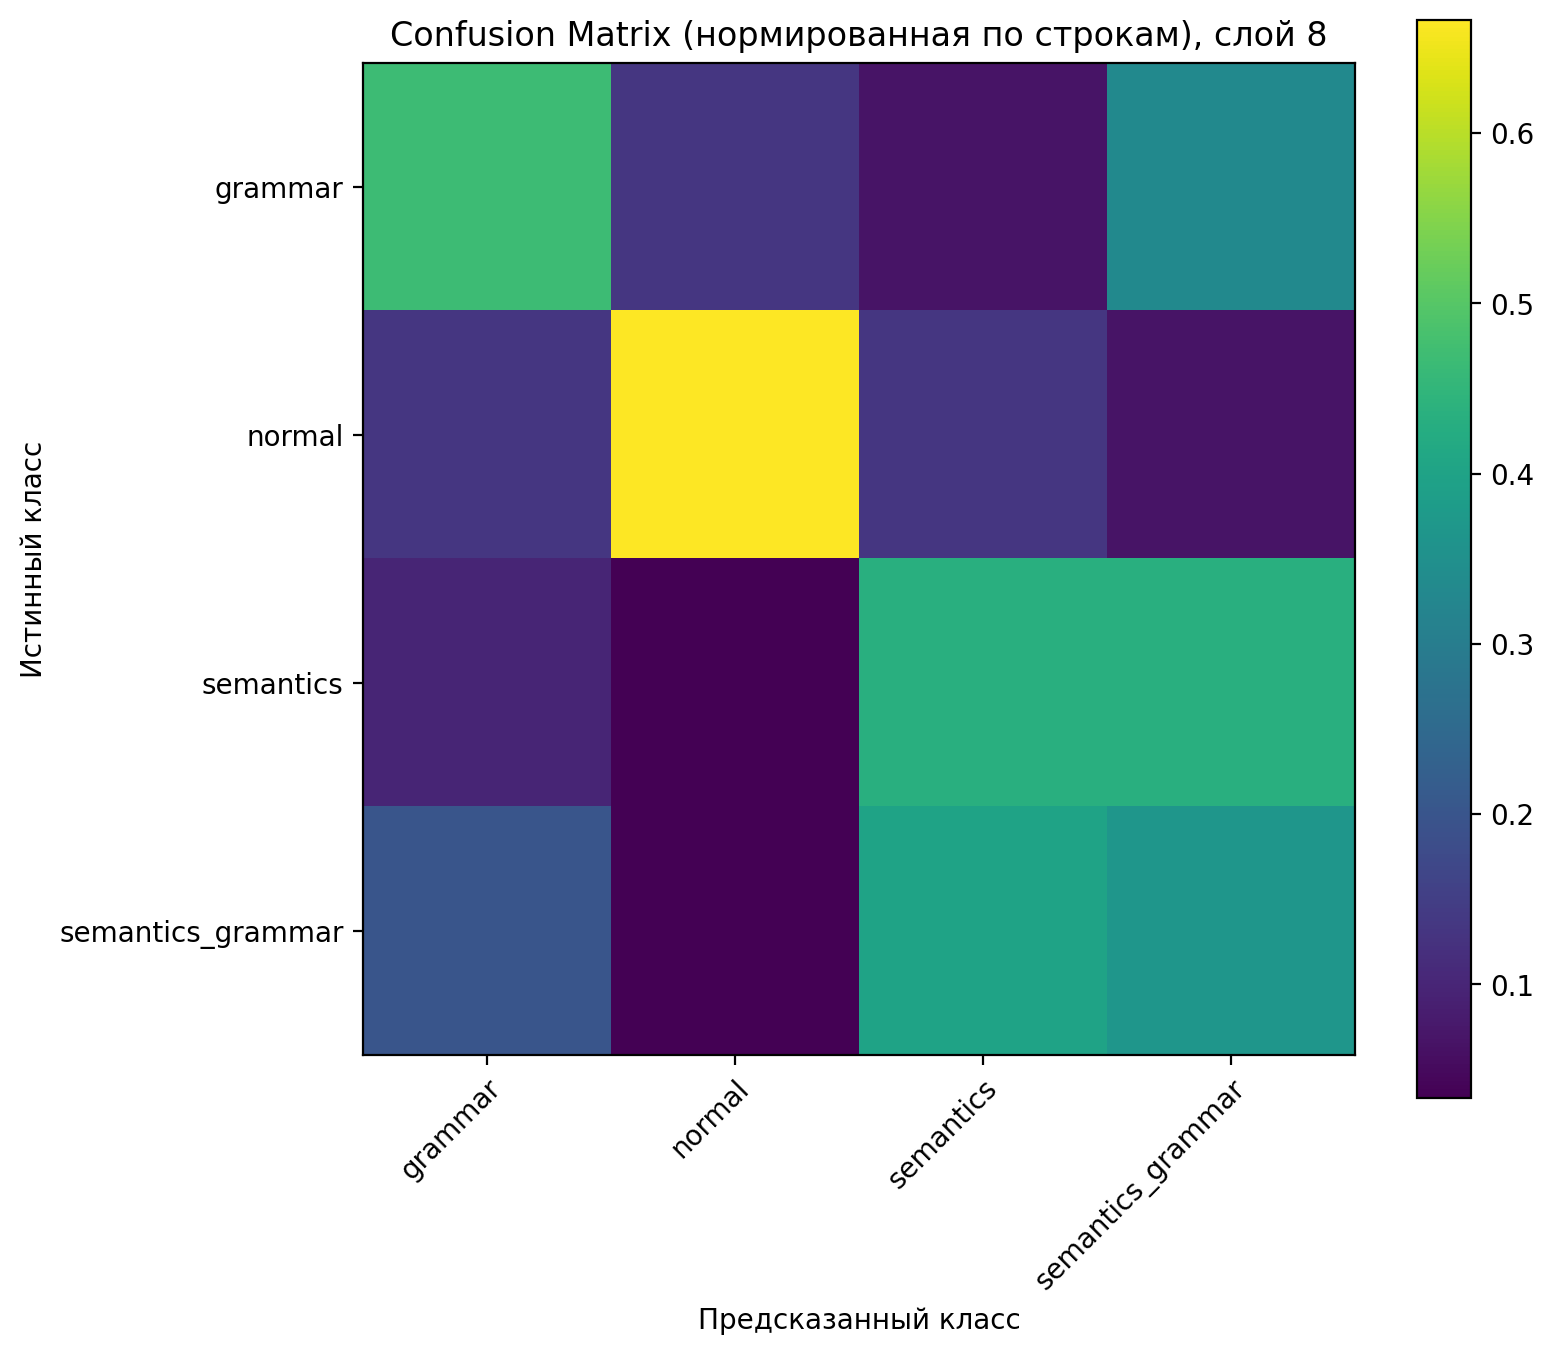

In [21]:
best_layer = int(results_df.iloc[0]["layer"])
best_C_for_best_layer = layer_to_bestC[best_layer]
df_best = df[df["layer"] == best_layer].reset_index(drop=True)
cm, labels = fit_for_confusion(df_best, C=best_C_for_best_layer, random_state=RANDOM_STATE, test_size=0.2)


cm = cm.astype(float)
row_sums = cm.sum(axis=1, keepdims=True)
row_sums[row_sums == 0.0] = 1.0
cm_norm = cm / row_sums

fig2, ax2 = plt.subplots(figsize=(8, 7))
im = ax2.imshow(cm_norm, interpolation="nearest")
ax2.figure.colorbar(im, ax=ax2)
ax2.set(
    xticks=np.arange(len(labels)),
    yticks=np.arange(len(labels)),
    xticklabels=labels,
    yticklabels=labels,
    xlabel="Предсказанный класс",
    ylabel="Истинный класс",
    title=f"Confusion Matrix (нормированная по строкам), слой {best_layer}"
)
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

In [22]:
thresh = cm_norm.max() / 2.0
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        val = cm_norm[i, j]
        ax2.text(j, i, f"{val:.2f}",
                 ha="center", va="center",
                 color="white" if val > thresh else "black")
plt.tight_layout()
cm_png = os.path.join(OUT_DIR, f"confusion_matrix_layer_{best_layer}.png")
plt.savefig(cm_png, dpi=150)
plt.show()
print(f"Сохранено: {cm_png}")


<Figure size 640x480 with 0 Axes>

Сохранено: probe_outputs/confusion_matrix_layer_8.png

Лучшие слои по F1-macro:
   layer  f1_macro_mean  f1_macro_std  accuracy_mean  accuracy_std  \
0      8       0.489134      0.021803       0.486667      0.024721   
1      5       0.488031      0.057252       0.488333      0.054836   
2     10       0.474982      0.023013       0.470000      0.022515   
3      9       0.473178      0.030118       0.468333      0.031950   
4      6       0.468951      0.033432       0.466667      0.038640   

   bestC_median  
0      4.641589  
1      4.641589  
2      1.000000  
3      4.641589  
4      1.000000  

Лучший слой: 8, медианный лучший C по outer-CV: 4.642


In [23]:
print("\nЛучшие слои по F1-macro:")
print(results_df[["layer", "f1_macro_mean", "f1_macro_std", "accuracy_mean", "accuracy_std", "bestC_median"]].head(5))
print(f"\nЛучший слой: {best_layer}, медианный лучший C по outer-CV: {best_C_for_best_layer:.4g}")


Лучшие слои по F1-macro:
   layer  f1_macro_mean  f1_macro_std  accuracy_mean  accuracy_std  \
0      8       0.489134      0.021803       0.486667      0.024721   
1      5       0.488031      0.057252       0.488333      0.054836   
2     10       0.474982      0.023013       0.470000      0.022515   
3      9       0.473178      0.030118       0.468333      0.031950   
4      6       0.468951      0.033432       0.466667      0.038640   

   bestC_median  
0      4.641589  
1      4.641589  
2      1.000000  
3      4.641589  
4      1.000000  

Лучший слой: 8, медианный лучший C по outer-CV: 4.642


In [24]:
def per_class_metrics_by_layer(df, layers=None, outer_splits=5, inner_splits=3):

    feature_cols = [c for c in df.columns if re.fullmatch(r"h_\d+", c)]
    feature_cols = sorted(feature_cols, key=lambda x: int(x.split("_")[1]))

    if layers is None:
        layers = sorted(df["layer"].unique())

    rows = []  # layer, class, f1_mean, f1_std, prec_mean, rec_mean

    for layer in layers:
        dfl = df[df["layer"] == layer].reset_index(drop=True)
        X = dfl[feature_cols].values
        y = dfl["target"].values
        labels = np.unique(y)

        outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=RANDOM_STATE)
        inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=RANDOM_STATE)

        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=2000))
        ])
        Cs = np.logspace(-2, 2, 7)
        grid = {"clf__C": Cs}

        f1_mat, prec_mat, rec_mat = [], [], []

        for tr, te in outer_cv.split(X, y):
            Xtr, Xte = X[tr], X[te]
            ytr, yte = y[tr], y[te]

            gs = GridSearchCV(pipe, grid, scoring="f1_macro", cv=inner_cv, n_jobs=-1, refit=True, verbose=0)
            gs.fit(Xtr, ytr)

            yhat = gs.predict(Xte)

            f1_mat.append(f1_score(yte, yhat, average=None, labels=labels))
            prec_mat.append(precision_score(yte, yhat, average=None, labels=labels, zero_division=0))
            rec_mat.append(recall_score(yte, yhat, average=None, labels=labels))

        f1_mat = np.vstack(f1_mat)
        prec_mat = np.vstack(prec_mat)
        rec_mat = np.vstack(rec_mat)

        f1_mean, f1_std   = f1_mat.mean(axis=0), f1_mat.std(axis=0, ddof=1)
        prec_mean, prec_std = prec_mat.mean(axis=0), prec_mat.std(axis=0, ddof=1)
        rec_mean, rec_std = rec_mat.mean(axis=0), rec_mat.std(axis=0, ddof=1)

        for lab, f1m, f1s, pm, ps, rm, rs in zip(labels, f1_mean, f1_std, prec_mean, prec_std, rec_mean, rec_std):
            rows.append({
                "layer": layer,
                "class": lab,
                "f1_mean": float(f1m), "f1_std": float(f1s),
                "precision_mean": float(pm), "precision_std": float(ps),
                "recall_mean": float(rm), "recall_std": float(rs),
            })

    return pd.DataFrame(rows)


In [25]:
def plot_class_layer_heatmap(df_long, metric="f1_mean", title=None, savepath=None):

    layers = sorted(df_long["layer"].unique())
    classes = sorted(df_long["class"].unique(), key=lambda x: str(x))

    M = np.zeros((len(classes), len(layers)))
    for i, c in enumerate(classes):
        row = df_long[df_long["class"] == c].set_index("layer").reindex(layers)
        M[i, :] = row[metric].values

    fig, ax = plt.subplots(figsize=(1.2*len(layers)+3, 0.5*len(classes)+3))
    im = ax.imshow(M, aspect="auto", interpolation="nearest")
    ax.figure.colorbar(im, ax=ax)
    ax.set_xticks(np.arange(len(layers)))
    ax.set_xticklabels(layers)
    ax.set_yticks(np.arange(len(classes)))
    ax.set_yticklabels(classes)
    ax.set_xlabel("Слой")
    ax.set_ylabel("Класс")
    ax.set_title(title or f"Теплокарта {metric} по классам и слоям")
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=150)
    plt.show()


In [26]:
def plot_per_class_curves(df_long, classes_to_show=None, metric="f1_mean", err="f1_std", max_classes=8, savepath=None):

    if classes_to_show is None:

        tmp = (df_long.groupby("class")[metric].mean().sort_values(ascending=False))
        classes_to_show = list(tmp.head(max_classes).index)

    fig, ax = plt.subplots(figsize=(10, 6))
    for cls in classes_to_show:
        sub = df_long[df_long["class"] == cls].sort_values("layer")
        ax.errorbar(sub["layer"].values, sub[metric].values,
                    yerr=sub[err].values, fmt="-o", capsize=3, label=str(cls))

    ax.set_xlabel("Слой")
    ax.set_ylabel(metric.replace("_", " "))
    ax.set_title(f"{metric} по слоям (с погр. {err})")
    ax.grid(True, alpha=0.3)
    ax.legend(ncol=2, fontsize=9)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=150)
    plt.show()


/opt/miniconda3/envs/SIGNAL-analysis/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/SIGNAL-analysis/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/SIGNAL-analysis/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/SIGNAL-analysis/lib/python3.12/site-packages/s

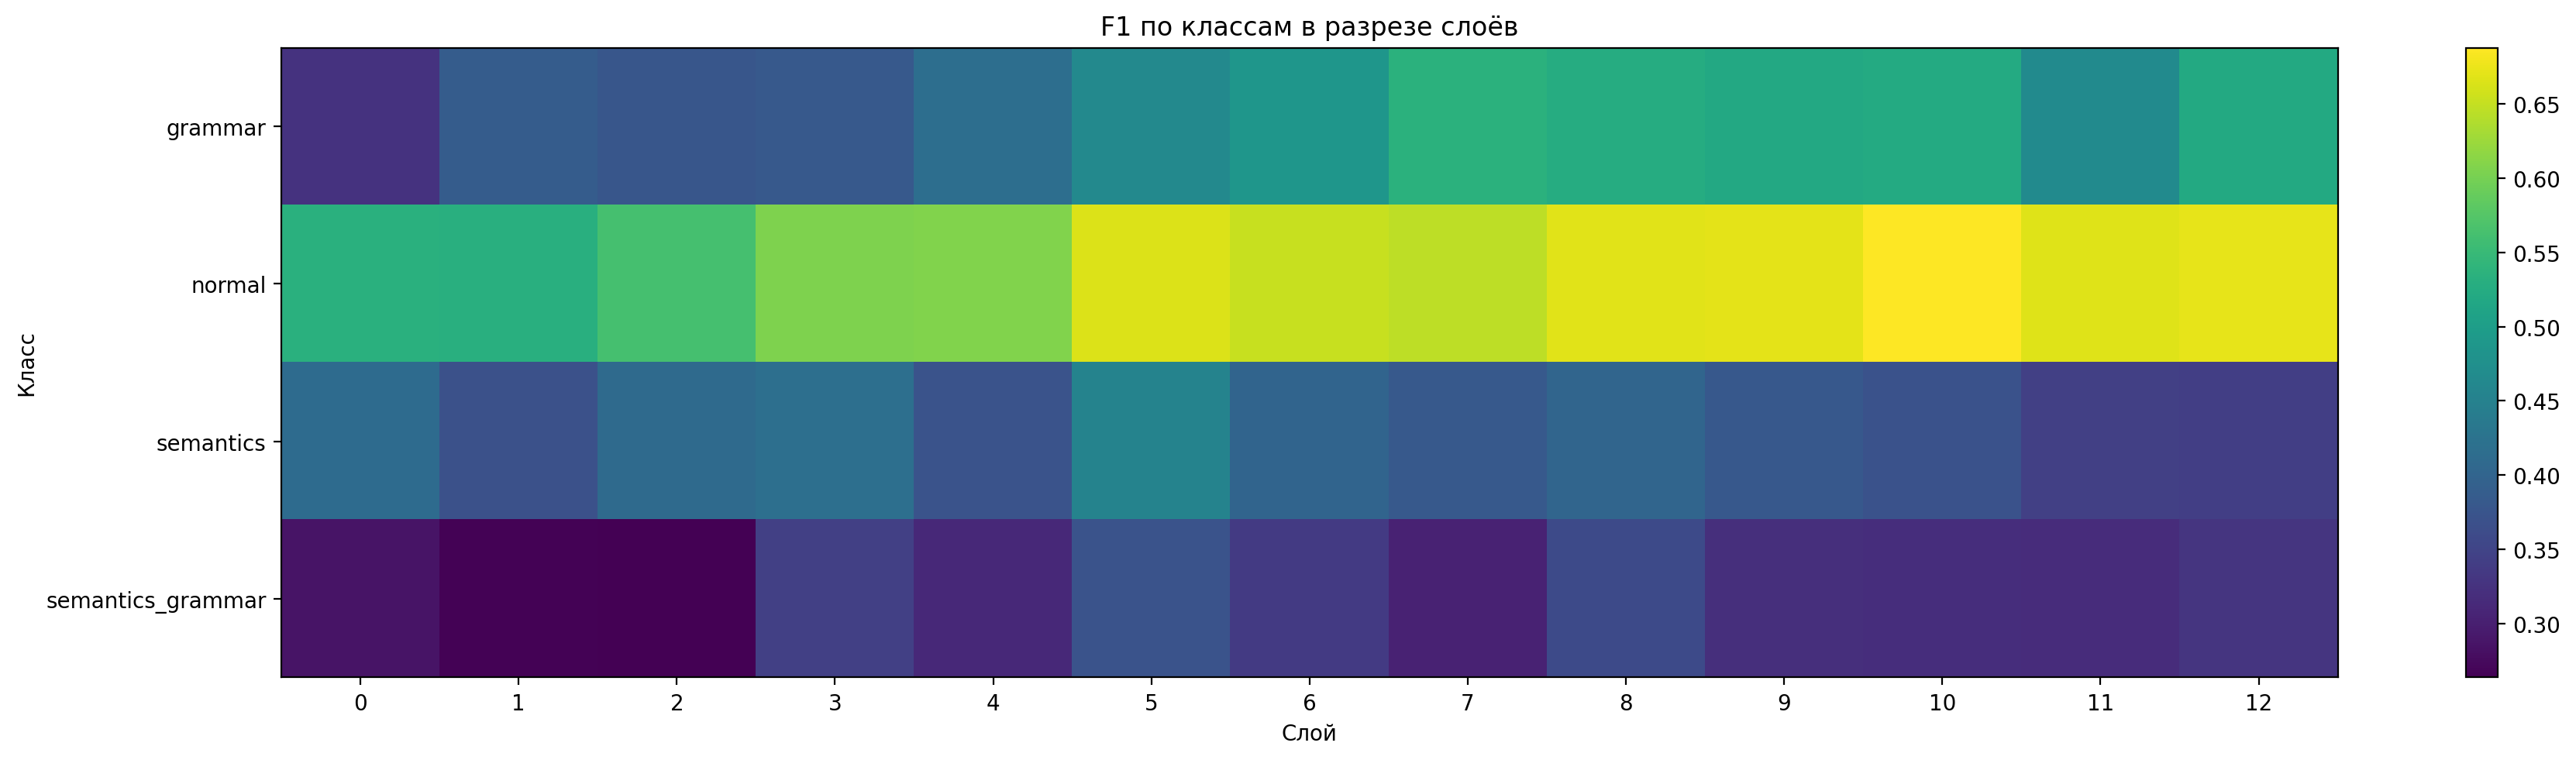

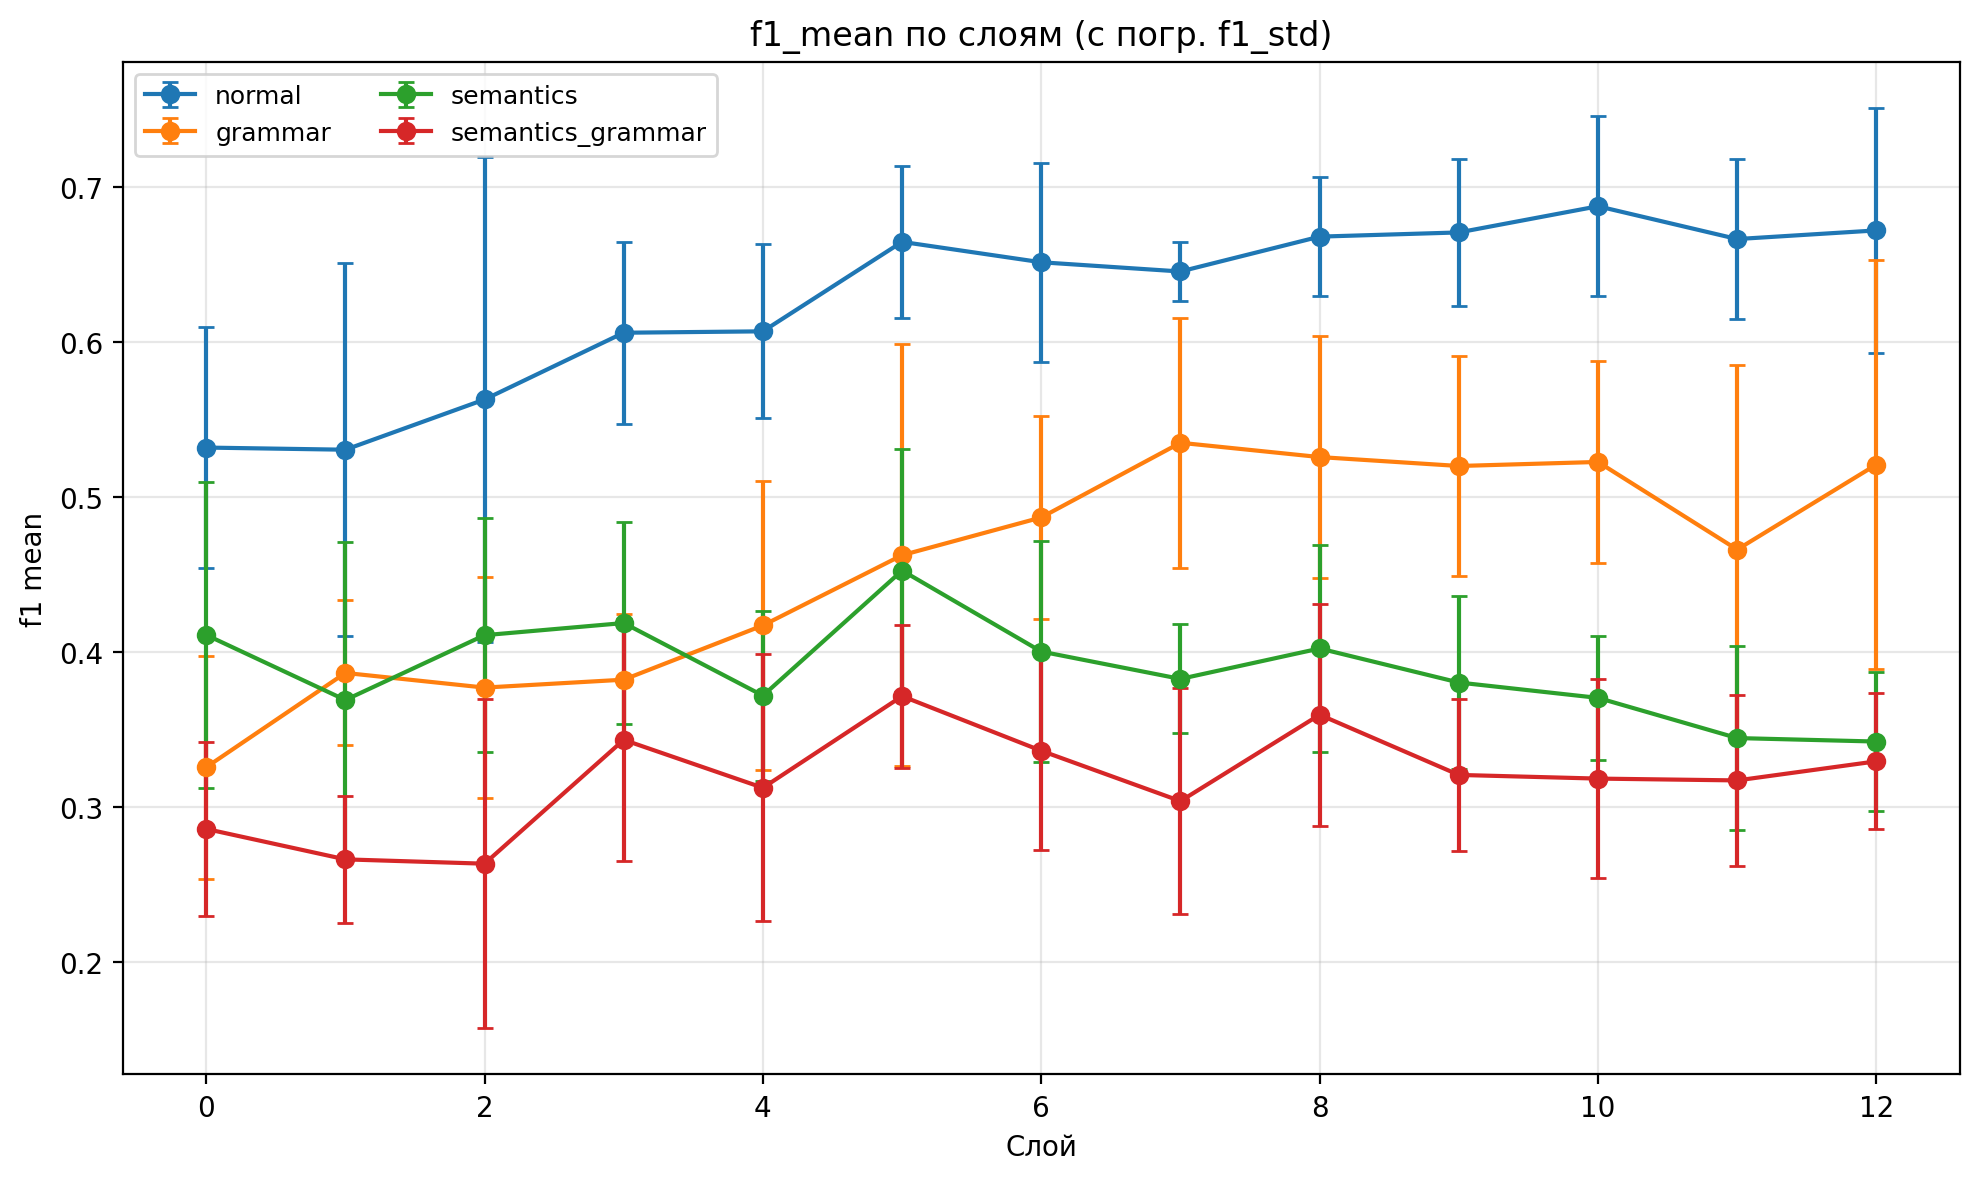

In [27]:
metrics_long = per_class_metrics_by_layer(df, outer_splits=5, inner_splits=3)

plot_class_layer_heatmap(metrics_long, metric="f1_mean",
                         title="F1 по классам в разрезе слоёв",
                         savepath="probe_outputs/class_by_layer_F1_heatmap.png")

plot_per_class_curves(metrics_long, metric="f1_mean", err="f1_std",
                      max_classes=8, savepath="probe_outputs/per_class_curves.png")
